# **Weak Instruments**

**Author:**
[Anthony Strittmatter](http://www.anthonystrittmatter.com)

In the following, we use a Monte-Carlo simulation to illustrate the bias of OLS under violations of the exclusion restriction and the vulnerability of IV when the first stage is weak. Because the data is artificial, we have control over the data generating process (DGP). Accordingly, we know the true underlying data model. 

## Load Packages

In [2]:
########################  Load Packages  ########################

# Load packages
library(AER) # Used for IV regression
library(ggplot2) # Used for density plot
options(warn=-1) # supress warnings

print('All packages successfully installed and loaded.')

[1] "All packages successfully installed and loaded."


## Select Parameters for Data Generating Process (DGP)

In [26]:
########################  Tuning Parameter Selection  ########################

N = 50 # Select sample size

beta = 0.5 # Specify size of effect of D on Y

bias_ols = 0.2 # Specify the size of the OLS bias

F = 2 # Specify first stage F-statistic

replications = 1000 # Select number of replications for Monte Carlo

sigma_Z = 1 # Specify noise of the DGP

print('Tuning parameters selected.')

[1] "Tuning parameters selected."


## First Stage Regresion

We generate one random draw from our DGP and test the power of the first stage.

In [40]:
## Data Generating Process ##

set.seed(12345689) # Set starting values

# Generate Instrument
Z <- rnorm(n=N, mean = 0, sd =sigma_Z)  
    
# Generate Treatment
sigma_D = sqrt((N-2)*sigma_Z^2/F) # Specify Variance of v
v <- rnorm(n=N, mean = 0, sd =sigma_D)
D <- Z + v

# Generate Outcome
frac  = bias_ols*(sigma_Z^2+sigma_D^2)/sigma_D^2
Y = beta*D + frac*v + rnorm(n=N)

## First Stage Regression ##

#OLS regression
first_stage <- lm(D ~ Z , data = as.data.frame(cbind(D,Z)))
summary(first_stage)
    
# Empirical F-statistic
F_emp = (N-2)*(first_stage$coefficient[2]^2*var(Z)/(var(D)))/(1-(first_stage$coefficient[2]^2*var(Z)/var(D)))
print(paste0("Empirical F-statistic: ",round(F_emp, digits =2)))

# Population F-statistic
F_true = (N-2)*(sigma_Z^2/(sigma_D^2+sigma_Z^2))/(1-(sigma_Z^2/(sigma_D^2+sigma_Z^2)))
print(paste0("True F-statistic: ",round(F_true, digits =2)))


Call:
lm(formula = D ~ Z, data = as.data.frame(cbind(D, Z)))

Residuals:
     Min       1Q   Median       3Q      Max 
-11.9379  -2.9541  -0.1115   2.7223  11.7711 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.6966     0.7114   0.979    0.332
Z             0.7608     0.6964   1.093    0.280

Residual standard error: 5.025 on 48 degrees of freedom
Multiple R-squared:  0.02427,	Adjusted R-squared:  0.003938 
F-statistic: 1.194 on 1 and 48 DF,  p-value: 0.28


[1] "Empirical F-statistic: 1.19"
[1] "True F-statistic: 2"


## OLS Regression of Y on D

In [21]:
## OLS ##

ols <- lm(Y ~ D, data = as.data.frame(cbind(Y,D)))
summary(ols) 


Call:
lm(formula = Y ~ D, data = as.data.frame(cbind(Y, D)))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4074 -0.7638 -0.2856  0.6918  2.8854 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.1077     0.1715   0.628    0.533    
D             0.7183     0.1659   4.329 7.56e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.212 on 48 degrees of freedom
Multiple R-squared:  0.2808,	Adjusted R-squared:  0.2658 
F-statistic: 18.74 on 1 and 48 DF,  p-value: 7.565e-05


## IV Regression of Y on D (with Instrument Z)

In [22]:
## IV ##

iv <- ivreg(formula = Y ~ D | Z, data = as.data.frame(cbind(Y,D,Z)))
summary(iv)


Call:
ivreg(formula = Y ~ D | Z, data = as.data.frame(cbind(Y, D, Z)))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3444 -0.8475 -0.2522  0.7339  3.0228 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.1050     0.1738   0.604  0.54865   
D             0.5296     0.1721   3.077  0.00345 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.229 on 48 degrees of freedom
Multiple R-Squared: 0.2614,	Adjusted R-squared: 0.2461 
Wald test:  9.47 on 1 and 48 DF,  p-value: 0.003446 


## Monte Carlo Simulation

Up to now, we generated only one random draw of the DGP and estimated the parameters of interst in this sample. But are the biases that we found systematic or did they occur just by chance? To answer this, we take many independent random draws of the DGP and estimate the parameters of interest in each sample. Afterwards, we can compare the distributions of the parameters, which gives us information about the finite sample properties of the estimators.

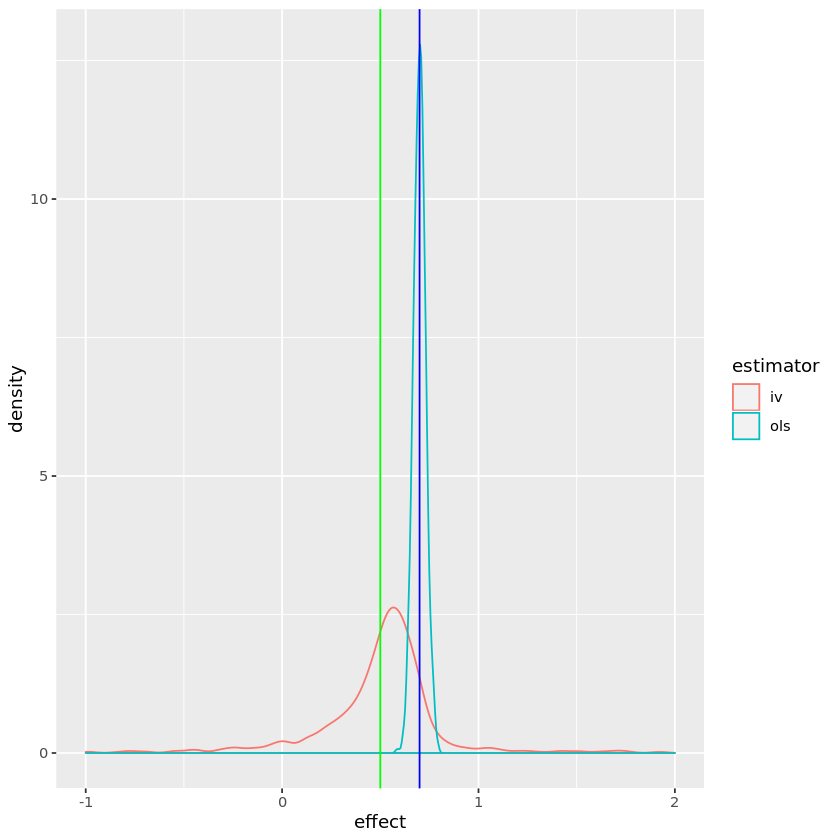

In [41]:
####### Monte Carlo Simulation #######

set.seed(123456789) # Set starting value

# Generate matrix to store results
effect <- matrix(NA, nrow = replications, ncol = 2)
colnames(effect) <- c("ols", "iv")

for (r in c(1:replications)) {
    
    ## Data Generating Process ##
    
    # Generate Instrument
    Z <- rnorm(n=N, mean = 0, sd =sigma_Z)  
    
    # Generate Treatment
    sigma_D = sqrt((F+N-2)*sigma_Z/F -sigma_Z) 
    v <- rnorm(n=N, mean = 0, sd =sigma_D)
    D <-  Z + v
    
    # Generate Outcome
    frac  = bias_ols*(sigma_Z^2+sigma_D^2)/sigma_D^2
    Y = beta*D + frac*v + rnorm(n=N)
    
    ## Estimation ##
    
    # OLS
    ols <- lm(Y ~ D, data = as.data.frame(cbind(Y,D)))
    effect[r,1] <- ols$coefficients[2] 
    
    # IV
    iv <- ivreg(formula = Y ~ D | Z, data = as.data.frame(cbind(Y,D,Z)))
    effect[r,2] <-iv$coefficients[2] 
}

# Density plot
dat <- data.frame(estimator = factor(rep(c("ols","iv"), each=replications)),
                effect = rbind(as.matrix(effect[,1]),as.matrix(effect[,2])))
ggplot(dat, aes(x=effect, colour=estimator)) + geom_density() + xlim((beta-1.5),(beta+1.5)) +
                geom_vline(xintercept = beta, color = "green") +
                geom_vline(xintercept = (beta+bias_ols), color = "blue")


Now go back to the snipplet were we specified the tuning parameters. You can play around with the tuning parameters and look at the finite sample performance of OLS and IV. For example, how does the finite sample performance of IV change when we increase the power of the first stage? Let's set $F= 10000$